In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

import os
import numpy as np
import shutil
import random

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
# mount drive to access the project
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
project_folder = "/content/drive/My Drive/w210_project/"
%cd $project_folder

/content/drive/My Drive/w210_project


In [5]:
data_folder = "/content/drive/My Drive/w210_project/dataset/classification/"
models_folder = "/content/drive/My Drive/w210_project/models/classification/"

# Set up data


In [6]:
# Calculate class balance TEST
%cd $data_folder

solar_count = !ls ./all_images/solar/ | wc -l
no_solar_count = !ls ./all_images/no_solar/ | wc -l
ratio = eval(solar_count[0]) / (eval(solar_count[0]) + eval(no_solar_count[0]))

print("Solar images count: {}".format(solar_count))
print("Non-Solar images count: {}".format(no_solar_count))
print("Ratio of solar images: {}".format(ratio))

/content/drive/My Drive/w210_project/dataset/classification
Solar images count: ['178']
Non-Solar images count: ['91']
Ratio of solar images: 0.6617100371747212


## Create train, val, test folders

In [ ]:
def create_train_val_test_folders(): 
  root_dir = './' # data root path
  classes_dir = ['solar', 'no_solar'] # two classes

  val_ratio = 0.15
  test_ratio = 0.05

  for cls in classes_dir:
      os.makedirs(root_dir +'train/' + cls)
      os.makedirs(root_dir +'val/' + cls)
      os.makedirs(root_dir +'test/' + cls)

      # Creating partitions of the data after shuffeling
      src = root_dir + "/all_images/" + cls 

      # get all files under a class folder
      allFileNames = os.listdir(src)
      np.random.shuffle(allFileNames)
      train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                                int(len(allFileNames)* (1 - test_ratio))])


      train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
      val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
      test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

      print('Total images: ', len(allFileNames))
      print('Training: ', len(train_FileNames))
      print('Validation: ', len(val_FileNames))
      print('Testing: ', len(test_FileNames))

      # Copy-pasting images
      for name in train_FileNames:
          shutil.copy(name, root_dir +'train/' + cls)

      for name in val_FileNames:
          shutil.copy(name, root_dir +'val/' + cls)

      for name in test_FileNames:
          shutil.copy(name, root_dir +'test/' + cls)

#create_train_val_test_folders()

Total images:  179
Training:  143
Validation:  27
Testing:  9
Total images:  92
Training:  73
Validation:  14
Testing:  5


In [31]:
# Setup loader for  data
PATH = data_folder
en_model = 'b1'
params_dict = {
        # Coefficients:   res
        'b0': (224, 224),
        'b1': (240, 240),
        'b2': (260, 260),
        'b3': (300, 300),
        'b4': (380, 380),
        'b5': (456, 456),
        'b6': (528, 528),
        'b7': (600, 600),
        'b8': (672, 672),
        'l2': (800, 800),
    }

inputsize = params_dict[en_model]
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')


BATCH_SIZE = 16
IMG_SIZE = inputsize

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 214 files belonging to 2 classes.


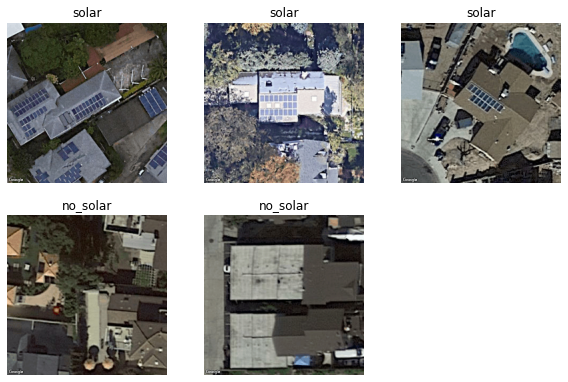

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [12]:
labels

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1], dtype=int32)>

## Configure datasets for performance

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


## Augmentation

In [34]:
#data_augmentation = tf.keras.Sequential([
#  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
#  tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),
#])
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


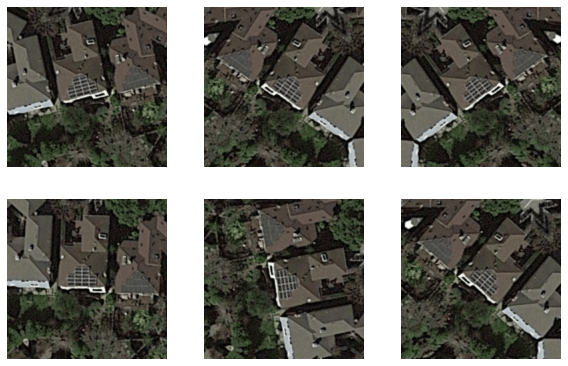

In [35]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


# Create Base EfficientNet Model

In [83]:
# get preprocess_input function
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [84]:
IMG_SIZE = (240, 240)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB1(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [85]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(10, 8, 8, 1280)


In [86]:
# freeze the convolutional base
base_model.trainable = False


In [ ]:
# Let's take a look at the base model architecture
base_model.summary()


In [87]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(10, 1280)


In [88]:
# add a prediction layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(10, 1)


In [89]:
# prepare model
inputs = tf.keras.Input(shape=(240, 240, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [90]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [91]:
len(model.trainable_variables)


2

In [92]:
initial_epochs = 50
loss0, accuracy0 = model.evaluate(validation_dataset)


5/5 [==============================] - 3s 23ms/step - loss: 0.7633 - accuracy: 0.3415


In [93]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/50
22/22 [==============================] - 7s 41ms/step - loss: 0.7729 - accuracy: 0.3411 - val_loss: 0.6914 - val_accuracy: 0.3659
Epoch 2/50
22/22 [==============================] - 1s 42ms/step - loss: 0.6983 - accuracy: 0.3925 - val_loss: 0.6464 - val_accuracy: 0.4878
Epoch 3/50
22/22 [==============================] - 1s 41ms/step - loss: 0.6539 - accuracy: 0.4766 - val_loss: 0.6192 - val_accuracy: 0.5122
Epoch 4/50
22/22 [==============================] - 1s 41ms/step - loss: 0.6350 - accuracy: 0.5140 - val_loss: 0.6047 - val_accuracy: 0.5366
Epoch 5/50
22/22 [==============================] - 1s 42ms/step - loss: 0.6241 - accuracy: 0.5794 - val_loss: 0.5955 - val_accuracy: 0.6341
Epoch 6/50
22/22 [==============================] - 1s 40ms/step - loss: 0.6195 - accuracy: 0.6075 - val_loss: 0.5891 - val_accuracy: 0.6829
Epoch 7/50
22/22 [==============================] - 1s 40ms/step - loss: 0.5944 - accuracy: 0.6449 - val_loss: 0.5835 - val_accuracy: 0.7073
Epoch 8/50
22

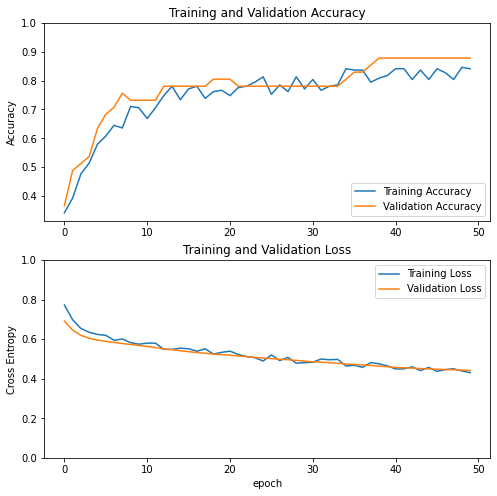

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# Fine Tune the Model

In [95]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  339


In [96]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [97]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [98]:
len(model.trainable_variables)


213

In [99]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 50/100
22/22 [==============================] - 17s 160ms/step - loss: 0.4258 - accuracy: 0.7944 - val_loss: 0.4105 - val_accuracy: 0.8537
Epoch 51/100
22/22 [==============================] - 2s 85ms/step - loss: 0.3708 - accuracy: 0.8598 - val_loss: 0.3813 - val_accuracy: 0.8780
Epoch 52/100
22/22 [==============================] - 2s 83ms/step - loss: 0.3193 - accuracy: 0.8692 - val_loss: 0.3675 - val_accuracy: 0.8780
Epoch 53/100
22/22 [==============================] - 2s 85ms/step - loss: 0.3049 - accuracy: 0.8692 - val_loss: 0.3562 - val_accuracy: 0.8780
Epoch 54/100
22/22 [==============================] - 2s 85ms/step - loss: 0.2791 - accuracy: 0.8879 - val_loss: 0.3362 - val_accuracy: 0.8780
Epoch 55/100
22/22 [==============================] - 2s 85ms/step - loss: 0.2397 - accuracy: 0.9112 - val_loss: 0.3449 - val_accuracy: 0.8780
Epoch 56/100
22/22 [==============================] - 2s 84ms/step - loss: 0.2283 - accuracy: 0.9159 - val_loss: 0.3163 - val_accuracy: 0.87

In [100]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


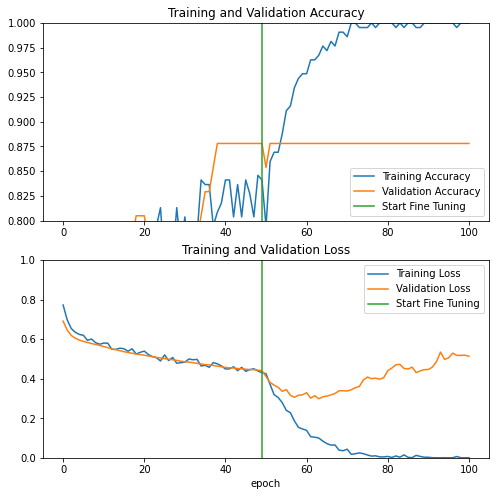

In [101]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [102]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


2/2 [==============================] - 0s 18ms/step - loss: 0.2138 - accuracy: 0.9286
Test accuracy : 0.9285714030265808


Predictions:
 [1 1 0 0 1 1 1 1 1 1]
Labels:
 [1 1 0 0 1 1 1 1 1 1]


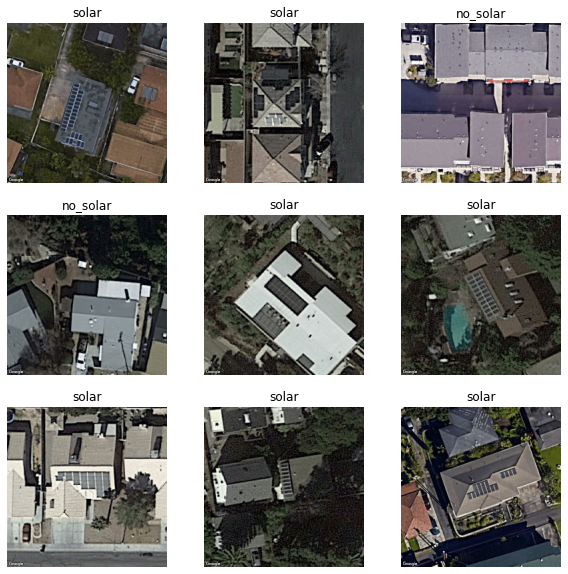

In [108]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [110]:
model.save(models_folder + 'en_solar_classifier_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [107]:
from tensorflow import keras
model = keras.models.load_model(models_folder + 'en_solar_classifier_model.h5')
